tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5618e-07, 1.5767e-07, 1.5993e-07,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9910e-04, 6.0618e-04, 6.1674e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


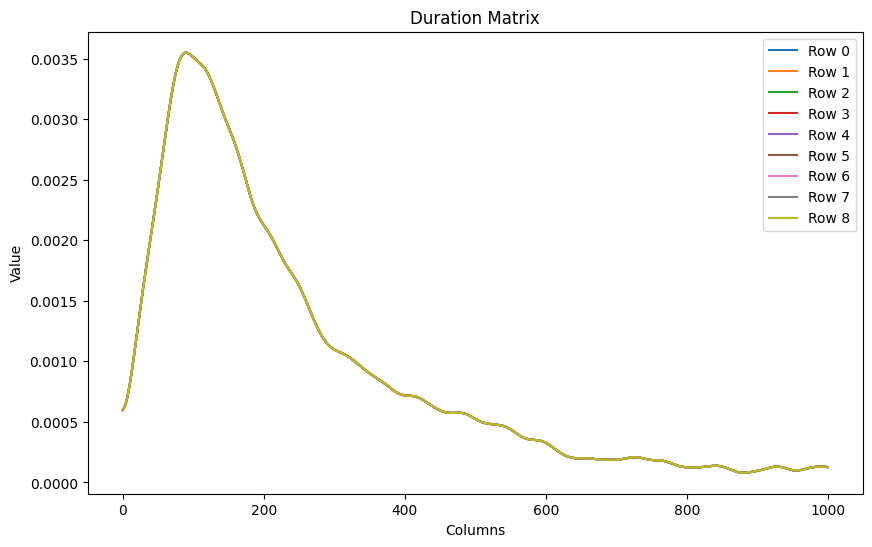

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import params
import tqdm.auto as tqdm
from collections import deque

# 0=S, 1=Es, 2=Ef, 3=Em, 4=El, 5=I, 6=5', 7=3', 8=epsilon
states = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
Transition = torch.tensor([[0.0, params.p1E, 1-params.p1E, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 1-params.pEO, params.pEO, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

Duration = torch.zeros(9, 5000000)
Duration[0, 0] = 1
Duration[1] = torch.tensor(params.lengthSingleExons)
Duration[2] = torch.tensor(params.lengthFirstExons)
Duration[3] = torch.tensor(params.lengthMiddleExons)
Duration[4] = torch.tensor(params.lengthLastExons)
Duration[5] = torch.tensor(params.lengthIntrons)
Duration[6, 0] = 1
Duration[7, 0] = 1
Duration[-1, 0] = 1
print(Duration)

# Plotting the matrix
plt.figure(figsize=(10, 6))
for i in range(Duration.shape[0]):
    plt.plot(Duration[2, :1000].numpy(), label=f"Row {i}")

plt.xlabel("Columns")
plt.ylabel("Value")
plt.title("Duration Matrix")
plt.legend(loc="upper right")
plt.show()



tensor([[1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
torch.Size([9, 1202])


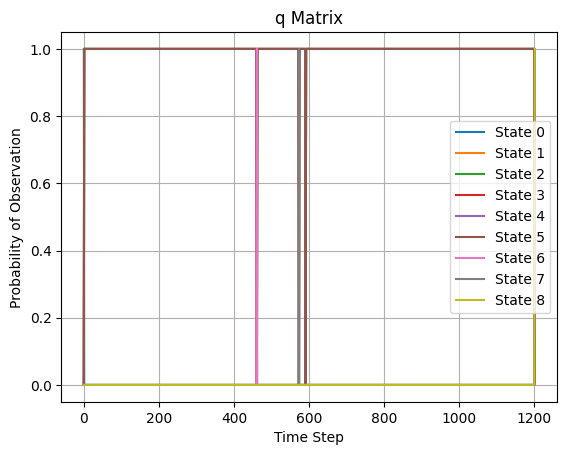

In [21]:
q3 = torch.tensor([[1], [0], [0]]).repeat(1, 1200) # [[null],[5'],[3']]
q3[:, 460] = torch.tensor([0, 1, 0]) # 5' site
q3[:, 572] = torch.tensor([0, 0, 1]) # 3' site
q3[:, 590] = torch.tensor([0.4, 0.6, 0]) # 5' site
print(q3)
q = torch.zeros(9, q3.shape[1])
q[1:6] = q3[0, :]
q[6] = q3[1, :]
q[7] = q3[2, :]
start = torch.zeros(9, 1)
start[0] = 1.0
end = torch.zeros(9, 1)
end[-1] = 1.0
q = torch.cat((start, q, end), dim=1)

print(q.shape)
# plot
time_steps = range(len(q[0]))
plt.figure()
for state in states:
    probs = [q[state][i].detach().numpy() for i in range(len(q[1]))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def matrix_mult_factor(log_alpha_row, Transition):
    alpha_row = torch.exp(log_alpha_row)
    alpha_row = alpha_row.to(torch.float64)
    product = alpha_row @ Transition
    factor = torch.sum(product)
    return torch.log(factor)

def matrix_mult_vec(log_alpha_row, Transition):
    log_alpha_row = log_alpha_row.to(torch.float64)
    result = torch.exp(log_alpha_row)@Transition
    if torch.sum(result) != 0:
        return torch.log(result / torch.sum(result))
    else:
        return torch.zeros_like(result)

  0%|          | 0/1202 [00:00<?, ?it/s]

0it [00:00, ?it/s]

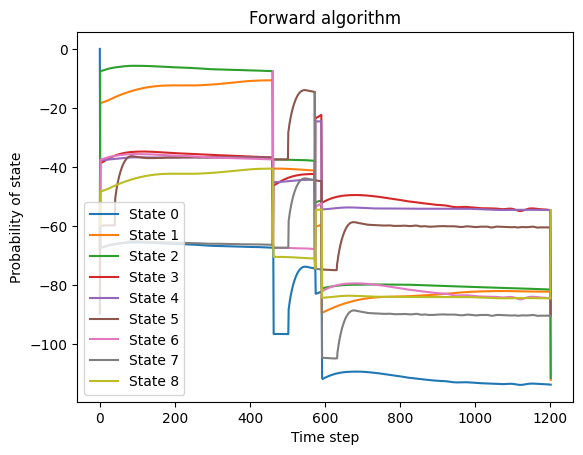

In [39]:
def forward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    # D = len(Duration[:, 0:1000][0])
    D = len(Duration[0])
    log_alpha_list = []
    start = torch.zeros(N)
    start[0] = 1
    epsilon = 1e-13

    Transition_ep = Transition + epsilon
    Duration_ep = Duration + epsilon
    q_ep = q + epsilon
    start_ep = start + epsilon

    cum_q_ep = torch.cumsum(torch.log(q_ep), axis=1)

    # initialization
    for t in tqdm.trange(min(D, T)):
        cumulative_terms = cum_q_ep[:, t]
        new_log_alpha = torch.log(start_ep) + torch.log(Duration_ep[:, t]) + torch.sum(torch.log(q_ep[:, :t+1]), dim=1)
        for d in range(t):
            factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition_ep)]*N) # calculate ahead of time
            vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition_ep) # same as above
            subtract_term = 0 if t-d == 0 else cum_q_ep[:, t-d-1]
            add_term = factor + vector + torch.log(Duration_ep[:, d]) + cumulative_terms - subtract_term # try to calcualte in one go
            new_log_alpha = torch.logaddexp(new_log_alpha, add_term).squeeze()
        log_alpha_list.append(new_log_alpha)
        
    # fill log_alpha[D:]
    for t in tqdm.trange(D, T):
        cumulative_terms = cum_q_ep[:, t]
        log_alpha_list.append(torch.full((N,), -float('inf')))
        new_log_alpha = log_alpha_list[t]
        for d in range(D):
            factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition_ep)]*N)
            vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition_ep)
            subtract_term = 0 if t-d == 0 else cum_q_ep[:, t-d-1]
            add_term = factor + vector + torch.log(Duration_ep[:, d]) + cumulative_terms - subtract_term
            new_log_alpha = torch.logaddexp(new_log_alpha, add_term).squeeze()
        log_alpha_list[t] = new_log_alpha

    log_alpha = torch.exp(torch.stack(log_alpha_list))
    return log_alpha


fwd = forward(states, Transition, q, Duration).detach().numpy()

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(q[0]))]
    plt.plot(time_steps, np.log(probs), label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

  0%|          | 0/1201 [00:00<?, ?it/s]

q.grad None
[1. 1. 1. 1. 1. 1. 1. 1. 1.] [1.00055428e-13 1.00000000e+00 1.99999915e-13 1.99999915e-13
 1.00000000e+00 1.99999915e-13 9.99999102e-14 1.00019175e-13
 9.99999102e-14]


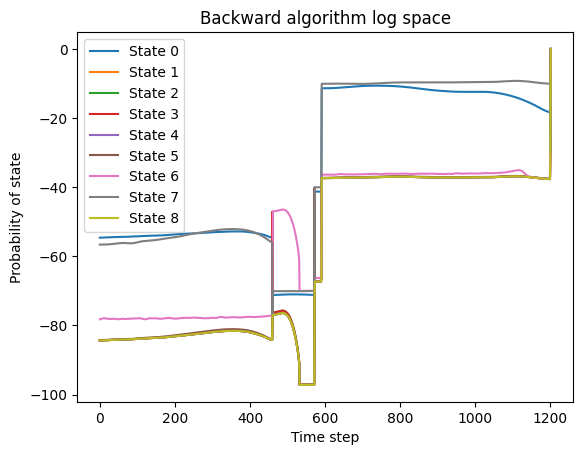

In [40]:
def backward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[0])
    epsilon = 1e-13
    log_beta = torch.full((T, N), -float('inf'))

    Transition_ep = torch.log(Transition + epsilon)
    Duration_ep = torch.log(Duration + epsilon)
    q_ep = q + epsilon

    cum_q_ep = torch.cumsum(torch.log(q_ep.flip(dims=[1])), dim=1).flip(dims=[1])

    # initialization, log_beta[-1]
    log_beta[-1] = torch.zeros(N)

    # fill log_beta[:-1]
    for t in tqdm.trange(T - 2, -1, -1):
        # cumulative_terms = cum_q_ep[:, t+1]
        for d in range(D):
            if t+d <= T-2:
                cumulative_terms = cum_q_ep[:, t+1] if t+d+1 >= T-1 else cum_q_ep[:, t+1] - cum_q_ep[:, t+d+2]
                log_beta[t] = torch.logaddexp(log_beta[t],
                                                torch.logsumexp(
                                                    torch.row_stack([log_beta[t+d+1]]*N)
                                                    + Transition_ep
                                                    + Duration_ep[:, d]
                                                    + cumulative_terms, axis=1))
            else:
                break

    log_beta = torch.exp(log_beta)
    return log_beta

bwd = backward(states, Transition, q, Duration).detach().numpy()
print('q.grad', q.grad)
print(bwd[-1], bwd[-2])

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(q[0]))]
    plt.plot(range(len(q[0])), np.log(probs), label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

In [25]:
def fb_alg(states, Transition, q, Duration):
    T = len(q[0])
    alpha = forward(states, Transition, q, Duration)
    beta = backward(states, Transition, q, Duration)
    fb_probs = alpha * beta

    # normalize
    fb_sum = torch.sum(alpha[T-1])
    if fb_sum:
        fb_probs = fb_probs / fb_sum
    
    #(fb_probs[2][2]).backward()
    return fb_probs

fb_probs = fb_alg(states, Transition, q, Duration).detach().numpy()
#print('q.grad:', (q.grad * 100).round().int())
print(fb_probs)

# plot
for state in states:
    probs = [fb_probs[t][state] for t in range(len(fb_probs))]
    plt.plot(range(1, len(fb_probs) + 1), np.log(probs), label=f'State {state}')

plt.xlabel('Time step')
plt.ylabel('Probability')
plt.title('Probabilities for Each State')
plt.legend()
plt.show()

  0%|          | 0/1202 [00:00<?, ?it/s]

KeyboardInterrupt: 